In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

import copy

In [2]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


### Import plotting utilities and planar drone locally or from github

In [6]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
generate_training_data_utility = import_local_or_github('generate_training_data_utility', directory='../Utility')

pysindy_utility = import_local_or_github('pysindy_utility', directory='../Utility')

extended_kalman_filter = import_local_or_github('extended_kalman_filter', directory='../Utility')
unscented_kalman_filter = import_local_or_github('unscented_kalman_filter', directory='../Utility')

# Planar drone dynamics

Now we will not include k as a static state. Instead, we will be using SINDy to find all the parameter values, which includes k.

#### Given the planar drone dynamics

$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{l}\bbox[lightblue]{k}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
\end{bmatrix}} \bbox[lightgreen]{j_1} +
\overset{f_2}{\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[lightblue]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
\bbox[lightblue]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m}  \\[0.3em]
\end{bmatrix}} \bbox[lightgreen]{j_2}
$

#### Consider the following sensor combinations:

$
\mathbf{y_c} = \mathbf{{h_c}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\dot{x}}/\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}}   \\[0.3em]
\ddot{x} = -\bbox[lightblue]{k} \sin(\bbox[yellow]{\theta}) \bbox[lightgreen]{j_1} / \bbox[lightblue]{m}  \\[0.3em]
\ddot{z} = -\bbox[lightblue]{g} + \bbox[lightblue]{k} \cos(\bbox[yellow]{\theta}) \bbox[lightgreen]{j_2}/ \bbox[lightblue]{m}
\end{bmatrix}
$

# Load SINDY models

In [25]:
dynamics_lambda_funcs, dynamics_coefficients = pysindy_utility.load_sindy_portable('sindy_dynamics_model.json')
dynamics_model = pysindy_utility.SINDY_INFERENCE_MODEL(dynamics_lambda_funcs, dynamics_coefficients).predict

In [26]:
measurements_lambda_funcs, measurements_coefficients = pysindy_utility.load_sindy_portable('sindy_measurement_model.json')
measurements_model = pysindy_utility.SINDY_INFERENCE_MODEL(measurements_lambda_funcs, measurements_coefficients).predict

### Wrap them to be compatible

In [27]:
class sindy_wrapper:
    def __init__(self, model):
        self.model = model
    def predict(self, x, u):
        return np.ravel(self.model(x, u))

In [29]:
sindy_f = sindy_wrapper(dynamics_model).predict
sindy_h = sindy_wrapper(measurements_model).predict

# Implement model with a UKF

Now let's use the SINDy model with a UKF.

To test the UKF we return to the same "squiggle" trajectory and larger dt that we used in the original UKF example.  

In [98]:
f = planar_drone.F(k=1).f
h = planar_drone.H('h_camera_imu', k=1).h

In [99]:
testing_data = planar_drone.simulate_drone(f, h, dt=0.1, tsim_length=20)
t_test = testing_data[0]
x_test = testing_data[1]
u_test = testing_data[2]
y_test = testing_data[3] # t_sim, x_sim, u_sim, y_sim, simulator

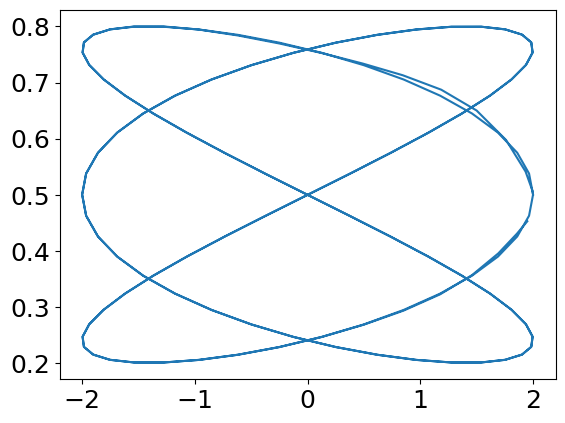

In [100]:
plt.plot(x_test['x'], x_test['z'])

In [101]:
measurement_noise_stds = {'optic_flow': 0.1,
                          'theta': 0.1,
                          'theta_dot': 0.1,
                          'accel_x': 0.2,
                          'accel_z': 0.2,
                         }

In [102]:
y_noisy = {key: y_test[key] + np.random.normal(0, measurement_noise_stds[key], len(y_test[key])) for key in y_test.keys()}

In [103]:
y_noisy_df = pd.DataFrame(y_noisy)
u_sim_df = pd.DataFrame(u_test)
x_sim_df = pd.DataFrame(x_test)

In [136]:
x0 = np.ones(x_sim_df.shape[1])*2
u0 = np.zeros(2)
P0 = np.eye(x_sim_df.shape[1])*1e-2 # <<< this is quite small to keep the filter smooth initially

R = np.diag( list(measurement_noise_stds.values()) )**2

# Note different values along diagonal here, tuned to make the filter work better.
# The values now reflect the trust in the model -- low trust in the thetadot eqn
Q = np.diag([1e-4, 1e-1, 1e-4, 1e-3, 1e-4, 1e-3])


dt = np.mean(np.diff(t_test))

In [152]:
UKF = unscented_kalman_filter.UKF(sindy_f, sindy_h, x0, u0, P0, Q, R,
                                 dynamics_type='continuous', discretization_timestep=dt,
                                 alpha=0.1)

In [153]:
UKF.estimate(y_noisy_df, u_sim_df)

In [154]:
# State estimate
x_est = pd.DataFrame(np.vstack(UKF.history['X']), columns=f(None,None,return_state_names=True))

# Covariance diagonals
P_diags = np.vstack([np.diag(UKF.history['P'][i]) for i in range(len(UKF.history['P']))])
P_diags = pd.DataFrame(P_diags, columns=f(None,None,return_state_names=True))

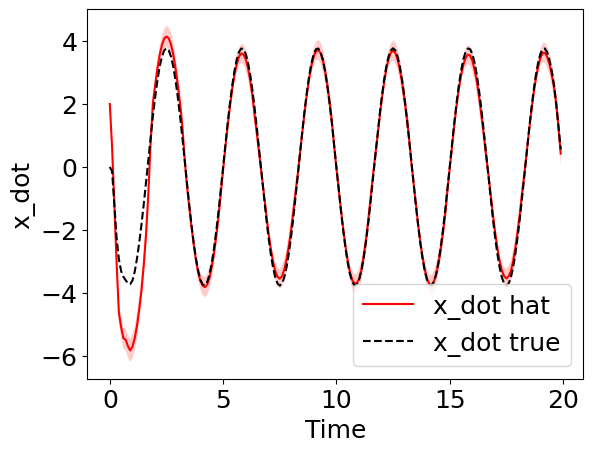

In [155]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'x_dot'

plot_tme(t_test, x_test[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_test, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

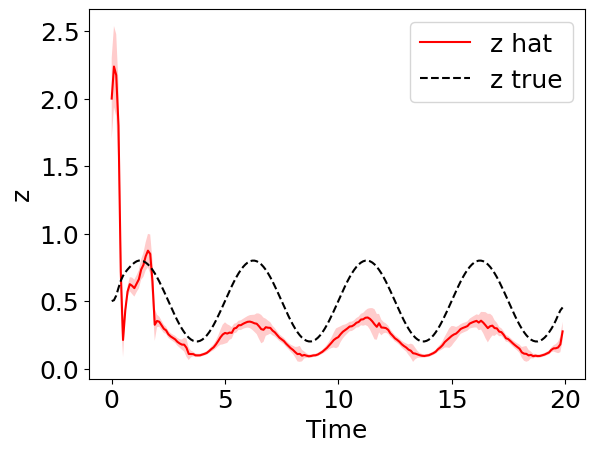

In [156]:
fig = plt.figure()
ax = fig.add_subplot(111)

state = 'z'

plot_tme(t_test, x_test[state], None, x_est[state], label_var=state, ax=ax)

plus3sigma = x_est[state] + 3*np.sqrt(P_diags[state])
minus3sigma = x_est[state] - 3*np.sqrt(P_diags[state])

ax.fill_between(t_test, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

# Conclusion

Very finnicky, but kind of okay. The measurement model is the fundamental issue: try replacing sindy_h with h. 

The issue here is almost certainly the optic flow measurement. Inspecting the sindy model, it did not do well with modelling that measurement. Probably could recast the problem so that we are not taking a reciprocal of altitude. 